In [2]:
import pandas as pd

In [3]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")

In [4]:
# to explicitly convert the date column to type DATETIME
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [5]:
data

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [6]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [7]:
# creating new dataframe from consumption column
data_consumption = data[['Consumption']]
# inserting new column with yesterday's consumption values
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'Consumption'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()
# dropping NAs
data_consumption = data_consumption.dropna()

/Users/jtst/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jtst/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [8]:
data_consumption

,Consumption,Yesterday,Yesterday_Diff
Date,,,
2006-01-03,1442.53300,1380.52100,311.33700
2006-01-04,1457.21700,1442.53300,62.01200
2006-01-05,1477.13100,1457.21700,14.68400
2006-01-06,1403.42700,1477.13100,19.91400
2006-01-07,1300.28700,1403.42700,-73.70400
...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345
2017-12-28,1299.86398,1263.94091,133.82408
2017-12-29,1295.08753,1299.86398,35.92307


In [9]:
X_train = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train = data_consumption.loc[:'2016', 'Consumption']
X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

In [13]:
from sklearn.model_selection import TimeSeriesSplit

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

LR: 0.343747 (0.029773)
NN: 0.448276 (0.155543)
KNN: 0.646307 (0.083185)
RF: 0.616673 (0.090977)
SVR: -0.117944 (0.157755)


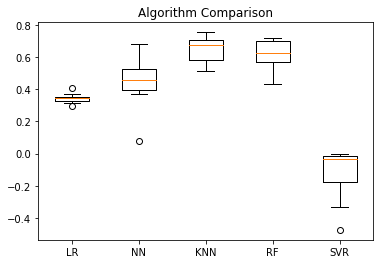

In [45]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [53]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [55]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [56]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.7357
mean_squared_log_error:  0.004
r2:  0.7334
MAE:  55.0418
MSE:  7220.6852
RMSE:  84.9746


In [57]:
# creating copy of original dataframe
data_consumption_2o = data_consumption.copy()
# inserting column with yesterday-1 values
data_consumption_2o['Yesterday-1'] = data_consumption_2o['Yesterday'].shift()
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_consumption_2o['Yesterday-1_Diff'] = data_consumption_2o['Yesterday-1'].diff()
# dropping NAs
data_consumption_2o = data_consumption_2o.dropna()

In [59]:
data_consumption_2o

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
Date,,,,,
2006-01-05,1477.13100,1457.21700,14.68400,1442.53300,62.01200
2006-01-06,1403.42700,1477.13100,19.91400,1457.21700,14.68400
2006-01-07,1300.28700,1403.42700,-73.70400,1477.13100,19.91400
2006-01-08,1207.98500,1300.28700,-103.14000,1403.42700,-73.70400
2006-01-09,1529.32300,1207.98500,-92.30200,1300.28700,-103.14000
...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408


In [60]:
X_train_2o = data_consumption_2o[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o = data_consumption_2o.loc[:'2016', 'Consumption']
X_test = data_consumption_2o['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o.loc['2017', 'Consumption']

In [61]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8444
mean_squared_log_error:  0.0024
r2:  0.8444
MAE:  39.8144
MSE:  4213.5382
RMSE:  64.9118


In [62]:
data_consumption_2o_solar = data_consumption_2o.join(data[['Solar']])
data_consumption_2o_solar = data_consumption_2o_solar.dropna()

In [63]:
data_consumption_2o_solar

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,Solar
Date,,,,,,
2012-01-01,948.12800,1077.62500,-122.24100,1199.86600,-27.02200,6.587
2012-01-02,1269.58100,948.12800,-129.49700,1077.62500,-122.24100,6.574
2012-01-03,1334.74500,1269.58100,321.45300,948.12800,-129.49700,24.679
2012-01-04,1347.13600,1334.74500,65.16400,1269.58100,321.45300,14.681
2012-01-05,1376.65800,1347.13600,12.39100,1334.74500,65.16400,5.071
...,...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392,16.530
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345,14.162
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408,29.854


In [64]:
X_train_2o_solar = data_consumption_2o_solar[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o_solar = data_consumption_2o_solar.loc[:'2016', 'Consumption']
X_test = data_consumption_2o_solar['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o_solar.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_solar, y_train_2o_solar)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8424
mean_squared_log_error:  0.0024
r2:  0.842
MAE:  40.0004
MSE:  4278.2108
RMSE:  65.408
